# Necessary (Train & Test)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [13]:
# The path to the folder that contains the dataset
current_folder_path = os.getcwd()
father_folder_path = os.path.dirname(current_folder_path)
data_folder_path = father_folder_path + '\\nyt_dataset\\'

In [14]:
train_file = pd.read_json(data_folder_path+"train_data.json",encoding="utf-8", orient='records')
valid_file = pd.read_json(data_folder_path+"valid_data.json",encoding="utf-8", orient='records')
test_file = pd.read_json(data_folder_path+"test_data.json",encoding="utf-8", orient='records')

In [15]:
train_tokens = [train_file['text'][i] for i in range(len(train_file['text']))]
train_label = [train_file['relation_list'][i][0]['predicate'] for i in range(len(train_file['relation_list']))]
valid_tokens = [valid_file['text'][i] for i in range(len(valid_file['text']))]
valid_label = [valid_file['relation_list'][i][0]['predicate'] for i in range(len(valid_file['relation_list']))]
test_tokens = [test_file['text'][i] for i in range(len(test_file['text']))]
test_label = [test_file['relation_list'][i][0]['predicate'] for i in range(len(test_file['relation_list']))]

In [16]:
training_df = pd.DataFrame(); testing_df = pd.DataFrame(); validating_df = pd.DataFrame()
training_df['Text'] = train_tokens; training_df['Ori_Label'] = train_label
validating_df['Text'] = valid_tokens; validating_df['Ori_Label'] = valid_label
testing_df['Text'] = test_tokens; testing_df['Ori_Label'] = test_label

In [17]:
# Make a list of all of the unique labels in the training and testing dataframes
labellist=sorted(list(set(training_df['Ori_Label'].unique()).union(set(testing_df['Ori_Label'].unique()))))
# Create a label dictionary
labels={label:i for i,label in enumerate(labellist)}
reverse_index={value:key for (key,value)in labels.items()}

In [18]:
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
# Create a dataset class that inherits the properties of the Dataset class in Torch to pre-process and store the data
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df,column='Text'):
        # Convert label names to label indices using the `labels` dictionary 
        self.labels=[labels[label] for label in df['Ori_Label']]
        # Tokenize the text data using the BERT tokenizer
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[column]]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])
    def get_batch_texts(self,idx):
        return self.texts[idx]
    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)
        return batch_texts,batch_y

# BERT

In [7]:
# Prepare inputs for the specific device (GPU or CPU) on which the model will run. Pre-check that GPU/CUDA is enabled
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def prepare_inputs(input1,label,device):
  label=label.to(device)
  mask=input1['attention_mask'].to(device)
  input_id=input1['input_ids'].squeeze(1).to(device)
  return (input_id,mask,label)

In [9]:
# Create a classification layer on top of BERT
class BertClassifier(nn.Module):
    # Define Bert model, Dropout layer, linear layer and activation function
    def __init__(self,dropout=0.5,num_classes=2):
        super(BertClassifier,self).__init__()
        self.bert=BertModel.from_pretrained('bert-base-cased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()
    # Define the computational flow of the model    
    def forward(self,input_id,mask):
        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)
        return final_layer

In [10]:
# Use the definitions of the initialisation method and the forward method of the BertClassifier class to sketch out what the neural network architecture looks like.
def train(model, train_data,val_data,learning_rate,epochs,batchSize):
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batchSize,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=batchSize)
    # Determine if cuda can be called, and call cpu if cuda cannot be called
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    # Define loss function, optimizer and learning rate
    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)
    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()
        
    for epoch_num in range(epochs):
        # Initialize the cumulative training set accuracy and training set loss
        total_acc_train=0
        total_loss_train=0
        # Set the model to training mode
        model.train()
        for train_input,train_label in tqdm(train_dataloader):
            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)
            output=model(input_id,mask)
            # Pass the input data to the model for forward propagation, calculate the loss, and accumulate the training set accuracy and training set loss
            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()
            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc
            # Clear the calculated gradient information
            model.zero_grad()
            # Calculate the gradient of the loss function with respect to the model parameters
            batch_loss.backward()
            # Update the parameters in the model to make it more optimal towards the training goal
            optimizer.step()
        # Initialize the cumulative validation set accuracy and validation set loss    
        total_acc_val=0
        total_loss_val=0
        # Set the model to evaluation mode
        model.eval()
        # Close gradient calculation
        with torch.no_grad():
            # Iterate through all the data in the validation set to evaluate the performance of the model
            for val_input,val_label in val_dataloader:
                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)
                output=model(input_id,mask)
                # Calculate and accrue losses
                batch_loss=criterion(output,val_label.long())
                total_loss_val+=batch_loss.item()
                # Cumulative number of correctly predicted samples
                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc
        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
      

# Hyperparameter

In [11]:
# Define the number of epochs, the learning rate and an instance of BertClassifier network.
model=BertClassifier(num_classes=len(labels.keys()))
model=model.to(device)
EPOCHS=6
LR=1e-5
batch_size=2

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train

In [ ]:
# Create training and validating datasets using the defined `Dataset` class
train_data=Dataset(training_df)
valid_data=Dataset(validating_df)

In [12]:
# Train the BERT model
train(model,train_data,valid_data,LR,EPOCHS,batch_size)

100%|██████████| 28098/28098 [1:38:56<00:00,  4.73it/s]


Epochs: 1 | Train Loss: 0.431 | Train Accuracy: 0.723
Val loss: 0.323 | Val Accuracy: 0.750


100%|██████████| 28098/28098 [1:37:53<00:00,  4.78it/s]


Epochs: 2 | Train Loss: 0.281 | Train Accuracy: 0.780
Val loss: 0.301 | Val Accuracy: 0.772


100%|██████████| 28098/28098 [1:36:09<00:00,  4.87it/s]


Epochs: 3 | Train Loss: 0.221 | Train Accuracy: 0.814
Val loss: 0.288 | Val Accuracy: 0.781


100%|██████████| 28098/28098 [1:35:05<00:00,  4.92it/s]


Epochs: 4 | Train Loss: 0.184 | Train Accuracy: 0.837
Val loss: 0.304 | Val Accuracy: 0.776


100%|██████████| 28098/28098 [1:35:17<00:00,  4.91it/s]


Epochs: 5 | Train Loss: 0.158 | Train Accuracy: 0.857
Val loss: 0.311 | Val Accuracy: 0.780


100%|██████████| 28098/28098 [1:34:42<00:00,  4.95it/s]


Epochs: 6 | Train Loss: 0.136 | Train Accuracy: 0.878
Val loss: 0.351 | Val Accuracy: 0.772


# Save Model

In [13]:
# Save model
current_folder_path = os.getcwd()
father_folder_path = os.path.dirname(current_folder_path)
data_folder_path = father_folder_path + '\\trained_model\\'
output_dir = data_folder_path + "bert-base-cased-textM-E" + str(EPOCHS)
torch.save(model,output_dir)

# Load Model

In [ ]:
# Loda model
class BertClassifier(nn.Module):
    # Define Bert model, Dropout layer, linear layer and activation function
    def __init__(self,dropout=0.5,num_classes=2):
        super(BertClassifier,self).__init__()
        self.bert=BertModel.from_pretrained('bert-base-cased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()
    # Define the computational flow of the model    
    def forward(self,input_id,mask):
        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)
        return final_layer

EPOCHS = 6
current_folder_path = os.getcwd()
father_folder_path = os.path.dirname(current_folder_path)
data_folder_path = father_folder_path + '\\trained_model\\'
input_dir = data_folder_path + "bert-base-cased-textM-E" + str(EPOCHS)
complete_model = torch.load(input_dir)

# Test

In [ ]:
# Model evaluation function
def evaluate(model,test_dataset,batchsize):
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)
    
    # Determine if cuda can be called, and call cpu if cuda cannot be called
    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model=model.cuda()
        
    total_acc_test=0
    with torch.no_grad():
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_label=test_label.to(device)
            mask=test_input['attention_mask'].to(device)
            input_id=test_input['input_ids'].squeeze(1).to(device)
            output=model(input_id,mask)
            # save the prediction for further analysis
            predictions.append(output.argmax(dim=1))  
            acc=(output.argmax(dim=1)==test_label).sum().item()
            
            total_acc_test+=acc
            
    # Show label prediction accuracy        
    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions

In [16]:
# Create testing dataset using the defined `Dataset` class
test_data=Dataset(testing_df)

In [17]:
# Test set label prediction
batchsize=2
predictions = evaluate(complete_model, test_data, batchsize)

100%|██████████| 2500/2500 [03:39<00:00, 11.37it/s]

Test accuracy:  0.757


In [18]:
# Add the predicted label for each test item to the dataframe with the test data
flattened=[]
for batch in predictions:
    for pred in batch:
        flattened.append(reverse_index[pred.item()])
testing_df['Predict_Label']=flattened

In [ ]:
result_pre_label = testing_df['Predict_Label']
result_ori_label = testing_df['Ori_Label']
resule_labels = list(set(list(result_ori_label)))

# Save Predict Result

In [30]:
# Save the dataframe with test data and predicted label
current_folder_path = os.getcwd()
father_folder_path = os.path.dirname(current_folder_path)
data_folder_path = father_folder_path + '\\result\\'
test_dir = data_folder_path + "BERT_result_TextM_E" + str(EPOCHS) + ".csv"
testing_df.to_csv(test_dir)

# Load Predict & Evaluation Result

[[   2    0    0    0    0    0    0    0    0    0    1    0    0    0
     0    0    0    0    0    0]
 [   0   11    0    1    0   16    0    0    0    0    0    0    0    1
     0    0    0    0    0    0]
 [   0    0    0    0   10    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0   17    0    6    1    0    0    4    1    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0   10    3    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0   10    0    0    3  336    0    0    0    3    0    1    0    1
     1    5    0    0    0    0]
 [   0    0    0    0    0    0   26   84   10   30    0    0    0    0
     6    0    0    0    0    0]
 [   0    0    0    0    0    1   29   74   14   19    0    0    0    0
     5    0    0    0    0    0]
 [   0    0    0    0    0    1    7   35  109  106    0    2    0    0
     5    0    2    1    0    0]
 [   0    0    0   12    0   43   18   70   66 2212   6

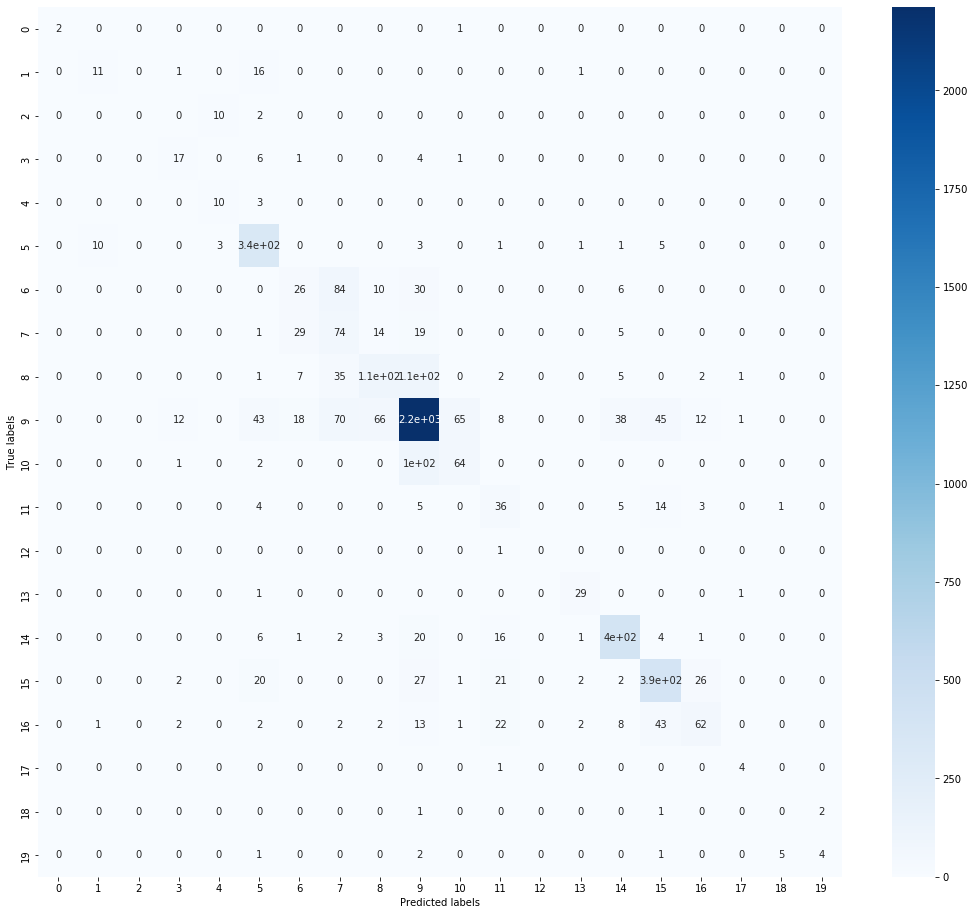

                                                    precision    recall  f1-score   support

                        /business/company/founders     1.0000    0.6667    0.8000         3
                       /location/location/contains     0.5000    0.3793    0.4314        29
                          /people/ethnicity/people     0.0000    0.0000    0.0000        12
                          /business/person/company     0.4857    0.5862    0.5312        29
                      /sports/sports_team/location     0.4348    0.7692    0.5556        13
                         /location/country/capital     0.7568    0.9333    0.8358       360
                        /people/person/place_lived     0.3171    0.1667    0.2185       156
            /people/deceased_person/place_of_death     0.2772    0.5211    0.3619       142
                   /business/company/place_founded     0.5343    0.4067    0.4619       268
                        /business/company/advisors     0.8692    0.8541    0.86

e:\AI\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\AI\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\AI\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
try:
  EPOCHS = 6
  current_folder_path = os.getcwd()
  father_folder_path = os.path.dirname(current_folder_path)
  data_folder_path = father_folder_path + '\\result\\'
  test_dir = data_folder_path + "BERT_result_TextM_E" + str(EPOCHS) + ".csv"
  result_file_dir = test_dir
  result_file = pd.read_csv(result_file_dir)
  result_pre_label = result_file['Predict_Label']
  result_ori_label = result_file['Ori_Label']
  resule_labels = list(set(list(result_ori_label)))

  confusion_matrix = confusion_matrix(result_ori_label, result_pre_label)
  print(confusion_matrix)

  plt.figure(figsize=(18, 16))
  sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

  print(classification_report(result_ori_label, result_pre_label, target_names=resule_labels, digits=4))
  
except:
  print('Select File Wrong!')

# Predict a New Sentence

## Necessary (Pridict)

In [ ]:
def predict_new_sentence(model, sentence, tokenizer, labels):
        use_cuda=torch.cuda.is_available()
        device=torch.device("cuda" if use_cuda else "cpu")
        model.eval()
        inputs = tokenizer(sentence, return_tensors="pt")
        input_id = inputs['input_ids'].to(device)
        mask = inputs['attention_mask'].to(device)
        output = model(input_id, mask)
        pred = output.argmax(dim=1)
        return labels[pred.item()]

def get_similar_token(entity, mymodel):
    similar_list = []
    # Add the similarity word to the list
    for idx, token in enumerate(entity):
        try:
            similar_list.append(mymodel.most_similar(positive=[token[0]]))
        except:
            similar_list.append([])
            print("The '" + token[0] + "' is not in the model")

    # Add original word to the list
    for i in range(len(entity)):
        similar_list[i].append((entity[i][0], entity[i][1]))
    
    return similar_list

def get_similar_sentence(entity, mymodel, tokens, entity_index):
    similar_token_list = get_similar_token(entity, mymodel)
    now_tokens_list = []
    if len(entity)==2:
        for i in range(len(similar_token_list[0])):
            tokens[entity_index[0]] = similar_token_list[0][i][0]
            for j in range(len(similar_token_list[1])):
                tokens[entity_index[1]] = similar_token_list[1][j][0]
                now_tokens = ' '.join(tokens)
                weight = similar_token_list[0][i][1] * similar_token_list[1][j][1]
                now_tokens_list.append([now_tokens, weight])
    else:
        for i in range(len(similar_token_list[0])):
            tokens[entity_index[0]] = similar_token_list[0][i][0]
            now_tokens = ' '.join(tokens)
            weight = similar_token_list[0][i][1]
            now_tokens_list.append([now_tokens, weight])
            
    return now_tokens_list

In [ ]:
# Load the NER model and word2vec model
from transformers import pipeline
NER = pipeline("ner")

from gensim.models import KeyedVectors
filename='GoogleNews-vectors-negative300.bin'
mymodel = KeyedVectors.load_word2vec_format(filename, binary=True)

## Enter a new sentence

In [ ]:
new_sentence = str(input("Enter the text you want to predict: "))
new_sentence_ori = new_sentence
new_sentence_ori

## Use BERT model and Word2vec model

In [ ]:
# Remove special characters
import re
new_sentence = re.sub(r'[^a-zA-Z ]', ' ', new_sentence)

# NER
score = [i['score'] for i in NER(new_sentence)]
word = [i['word'] for i in NER(new_sentence)]

# Get two entity
entity = []
if len(word) >= 1:
    word.index(max(word))
    entity.append([word[word.index(max(word))], score[word.index(max(word))]])
    if len(word) >= 2:
        word.pop(word.index(max(word)))
        entity.append([word[word.index(max(word))], score[word.index(max(word))]])

    print(entity)

    # Get tokens and entity index in tokens
    B_W_sentence = new_sentence
    tokens = B_W_sentence.split(' ')

    # entity_index = [tokens.index(entity[i][0]) for i in range(len(entity))]
    entity_index = []
    n = 0
    for i in range(len(entity)):
        try:
            entity_index.append(tokens.index(entity[i][0]))
        except:
            n+=1
            entity_index.append(0)
            print("The entity '" + entity[i][0] + "' is not in the sentence")
    
    if n == 2:
        predict_results = "/"

    else:
        # Replace entity with similar token
        now_tokens_list = get_similar_sentence(entity, mymodel, tokens, entity_index)

        # Predict the result
        predict_results = {label:0 for i,label in enumerate(labellist)}
        for i in range(len(now_tokens_list)):
            predict_result = predict_new_sentence(complete_model, now_tokens_list[i][0], tokenizer, reverse_index)
            predict_results[predict_result] = predict_results[predict_result] + now_tokens_list[i][1]

        # Remove relations that were never predicted
        move_list = []
        for k,v in predict_results.items():
            if v == 0:
                move_list.append(k)
        for i in move_list:
            predict_results.pop(i)

        # Sort the results
        predict_results = dict(sorted(predict_results.items(), key=lambda item: item[1], reverse=True))

else:
    predict_results = "/"
    print("Cannot find entity in the sentence")

## Predict result

In [ ]:
predict = predict_new_sentence(complete_model, new_sentence, tokenizer, reverse_index)
print("The sentence is          : ", new_sentence_ori)
print("\nThe predicted of BERT is : ", predict)
print("\nThe predicted OF BERT & Word2vec is: ")
predict_results